# 3a

In [23]:
from scipy.io import loadmat
import numpy as np

# load dataset
dataset_1 = loadmat('occam1.mat')
dataset_2 = loadmat('occam2.mat')

In [24]:
import math

In [25]:
dataset_1['x'].shape

(15, 1)

In [26]:
dataset_2['x'].shape

(100000, 1)

In [27]:
# compute the gradients according to 1c
def compute_gradients(X, y, alpha_2, sigma_2, phi, z=None):
    # return gradient_z, gradient_alpha, gradient_sigma
    # precalculate phi(X, z) so we don't have to calculate it several times
    phi_xz = phi(X, z)
    phi_t = phi_xz.T
    N, k = phi_xz.shape
    
    # calculate Sigma since we also use it several times
    Sigma = (1 / alpha_2) * np.identity(k) + (1 / sigma_2) * phi_t @ phi_xz
    
    # add jitter, according to hint 3
    jitter_amount = 1e-6
    Sigma = Sigma + jitter_amount * np.identity(k)
    
    # invert
    sigma_inv = np.linalg.inv(Sigma)

    # default initialization
    gradient_z = 0
    
    if phi.z_shape != 0:
        gradient_z = []
        # for each dimension of z
        for i in range(len(z)):
            # take the derivative with respect to that dimension
            phi_derivative = phi.z_derivative(X.squeeze(), z)[i]
            phi_t_derivative = phi.z_derivative(X.squeeze(), z)[i].T

            sigma_derivative = (phi_t_derivative @ phi_xz + phi_t @ phi_derivative) / sigma_2

            # calculate gradient
            gradient_z_i = 0.5 * (- np.trace(sigma_inv @ sigma_derivative)
                                  + (y.T @ phi_derivative @ sigma_inv @ phi_t @ y
                                     - y.T @ phi_xz @ sigma_inv @ sigma_derivative @ sigma_inv @ phi_t @ y
                                     + y.T @ phi_xz @ sigma_inv @ phi_t_derivative @ y
                                     ) / (sigma_2 ** 2)
                                  )
            gradient_z.append(gradient_z_i.item())

    # calculate alpha and sigma gradient according to 1c
    gradient_alpha = 0.5 * (- k / alpha_2
                            + np.trace(sigma_inv) / (alpha_2 ** 2)
                            + y.T @ phi_xz @ sigma_inv @ sigma_inv @ phi_t @ y / (sigma_2 ** 2 * alpha_2 ** 2))
    
    gradient_sigma = - 0.5 * (N / sigma_2
                              - np.trace(sigma_inv @ phi_t @ phi_xz) / (sigma_2 ** 2)
                              - y.T @ y / (sigma_2 ** 2)
                              - y.T @ phi_xz @ (sigma_inv @ phi_t @ phi_xz @ sigma_inv / sigma_2
                                                - 2 * sigma_inv) @ phi_t @ y / (sigma_2 ** 3)
                              )
    # return list, float, float
    return gradient_z, gradient_alpha.item(), gradient_sigma.item()

In [28]:
# gradient checker function: perturb a single dimension by epsilon and measure the difference
def gradient_checker(gradient, objective_func, X, y, alpha, sigma, phi, z, check_variable,
                     idx_z_check=0, epsilon=1e-4, tolerance=1e-2):
    if check_variable == 'alpha':
        approx_gradient = (objective_func(X, y, alpha + epsilon, sigma, phi, z)
                           - objective_func(X, y, alpha - epsilon, sigma, phi, z)
                           ) / (2 * epsilon)
    elif check_variable == 'sigma':
        approx_gradient = (objective_func(X, y, alpha, sigma + epsilon, phi, z)
                           - objective_func(X, y, alpha, sigma - epsilon, phi, z)
                           ) / (2 * epsilon)
    elif check_variable == 'z':
        approx_gradient = (objective_func(X, y, alpha, sigma, phi, z + np.array([epsilon * (idx == idx_z_check)
                                                                                 for idx in range(len(z))]))
                           - objective_func(X, y, alpha, sigma, phi, z - np.array([epsilon * (idx == idx_z_check)
                                                                                   for idx in range(len(z))]))
                           ) / (2 * epsilon)
    # check the norm of the distance between the perturbed, numerical gradient and the analytical gradient
    distance = np.linalg.norm(gradient - approx_gradient.item())
    if distance > tolerance:
        raise ValueError(f'Gradient did not match for parameters: alpha={alpha}, '
                         f'sigma={sigma}, phi={phi}, z={z}, gradient={gradient}, '
                         f'approx_gradient={approx_gradient.item()}, variable={check_variable}'
                         )
    return

In [29]:
# the "original" version of 1b, without caring about dimensionality
def calc_log_marginal_likelihood_old(X, y, alpha_2, sigma_2, phi, z=None):
    N = X.shape[0]
    # phi @ phi.T yields (N,N) shape matrix, which doesn't work for dataset 2
    Sigma = sigma_2 * np.identity(N) + alpha_2 * phi(X, z) @ phi(X, z).T
    
    # add jitter, according to hint 3
    jitter_amount = 1e-6
    Sigma = Sigma + jitter_amount * np.identity(N)

    # LML terms
    first = - N * np.log(2 * np.pi) / 2
    second = - np.log(np.linalg.det(Sigma)) / 2
    third = - y.T @ np.linalg.inv(Sigma) @ y / 2

    return first + second + third

In [30]:
# 1b with better dimensionality
def calc_log_marginal_likelihood(X, y, alpha_2, sigma_2, phi, z=None):
    # precalculation to avoid repeated evaluation of phi
    phi_xz = phi(X, z)
    N, phi_shape = phi_xz.shape
    phi_t = phi_xz.T
    # sigma is now (param_count_phi, param_count_phi) shape
    Sigma = (1 / alpha_2) * np.identity(phi_shape) + (1 / sigma_2) * phi_t @ phi_xz
    
    # add jitter, according to hint 3
    jitter_amount = 1e-6
    Sigma = Sigma + jitter_amount * np.identity(phi_shape)

    # LML terms
    first = - N * np.log(2 * np.pi) / 2
    second = - N * math.log(alpha_2 ** (phi_shape / N) * sigma_2) / 2
    third = - math.log(np.linalg.det(-Sigma)) / 2
    fourth = - y.T @ y / (2 * sigma_2)
    fifth = y.T @ phi_xz @ np.linalg.inv(Sigma) @ phi_t @ y / (2 * (sigma_2 ** 2))

    return first + second + third + fourth + fifth

In [31]:
class Model_1(object):
    # model 1, according to 3a
    def __init__(self):
        # z doesn't matter
        self.z_shape = 0
        self.z_derivative = lambda x, z: None
    
    def __call__(self, x, *args):
        # calling model_1(X, z) returns 1, x, x^2, x^3, x^4, x^5
        return np.stack([np.ones(x.shape),
                         x,
                         x ** 2,
                         x ** 3,
                         x ** 4,
                         x ** 5],
                        ).squeeze().T

class Model_2(object):
    def __init__(self):
        # z has two elements
        self.z_shape = 2
    
    def z_derivative(self, x, z):
        # derivatives of phi(x, z) with respect to z, for each element of z
        # this is technically a tensor, but is implemented as a list of matrices
        # shaped (2, N, 2)
        return [np.stack([2 * (x - 1) ** 2 * np.exp(- ((x - 1) ** 2) / (z[0] ** 2)) / (z[0] ** 3),
                         np.zeros(x.shape)]).T,
                np.stack([np.zeros(x.shape),
                          2 * (x - 5) ** 2 * np.exp(- ((x - 5) ** 2) / (z[1] ** 2)) / (z[1] ** 3),]).T
                ]
    
    def __call__(self, x, z):
        # phi_2 (X, z)
        return np.stack([np.exp(- ((x - 1) ** 2 / z[0] ** 2)),
                         np.exp(- ((x - 5) ** 2 / z[1] ** 2))],
                         ).squeeze().T

class Model_Test(object):
    # for testing purposes
    def __init__(self):
        self.z_shape = 2
    
    def z_derivative(self, x, z):
        # (2, N, 2) shape tensor
        return [np.stack([x, np.zeros(x.shape)]).T,
                np.stack([np.zeros(x.shape), x ** 2]).T
                ]

    def __call__(self, x, z):
        # simple functions to make sure the derivatives for model 2 were not the problem
        return np.stack([x * z[0], z[1] * x ** 2]).squeeze().T
    
class Model_3(object):
    def __init__(self):
        # z doesn't matter again
        self.z_shape = 0
        self.z_derivative = lambda x, z: None
    
    def __call__(self, x, *args):
        # phi_3(X, z)
        return np.stack([x,
                         np.cos(2 * x)],
                        ).squeeze().T

In [32]:
# initialize the models
model_1 = Model_1()
model_2 = Model_2()
model_3 = Model_3()
model_test = Model_Test()

In [33]:
# small test for compute_gradients to see if it runs
compute_gradients(dataset_1['x'],
                  dataset_1['y'],
                  13.79,
                  213.44,
                  model_1,
                  z=None,
                  )

(0, -0.043093644619835, 0.3305149266941671)

In [34]:
# same for calculating LML
calc_log_marginal_likelihood(dataset_1['x'], dataset_1['y'], 4, 3, model_1, [1, 2])

array([[-4757.08427572]])

In [35]:
# checking if gradient checker works
gradient_checker(-201.8404, calc_log_marginal_likelihood,
                 dataset_1['x'], dataset_1['y'], 4, 3, model_2, np.array([1, 2]), 'z', idx_z_check=0, epsilon=1e-6)

In [44]:
# batch gradient ascent code adapted from my 1003 code
def batch_grad_ascent(X, y, step_size_alpha=0.1, step_size_sigma=1, step_size_z=0.1,
                       phi=None, grad_check=False):

    # initialization procedures
    likelihood_history = []
    alpha_history = [1]
    sigma_history = [1]
    num_instances, num_features = X.shape[0], 1
    z = np.ones(phi.z_shape)
    alpha = 500
    sigma = 500
    iteration = 0
    
    # start the LML here
    log_marginal_likelihood = calc_log_marginal_likelihood(X, y, alpha, sigma, phi, z)
    likelihood_history.append(log_marginal_likelihood.item())
    
    if phi is None:
        raise NotImplementedError
    
    # while not converged
    while True:
        iteration += 1
        # compute the gradients
        gradient_z, gradient_alpha, gradient_sigma = compute_gradients(X, y, alpha, sigma, phi, z)
        if grad_check:
            gradient_checker(gradient_alpha, calc_log_marginal_likelihood, X, y, alpha, sigma, phi, z, check_variable='alpha')
            gradient_checker(gradient_sigma, calc_log_marginal_likelihood, X, y, alpha, sigma, phi, z, check_variable='sigma')
            gradient_checker(gradient_z, calc_log_marginal_likelihood, X, y, alpha, sigma, phi, z, check_variable='z')
        # step in the gradient direction (ascent, not descent)
        # ensure that we do not go beyond 0 for alpha/sigma
        z = [z[i] + step_size_z * gradient_z[i] for i in range(len(z))]
        alpha = max(1e-16, alpha + step_size_alpha * gradient_alpha)
        sigma = max(1e-16, sigma + step_size_sigma * gradient_sigma)
        
        # calculate the updated LML
        log_marginal_likelihood = calc_log_marginal_likelihood(X, y, alpha, sigma, phi, z)
        
        if iteration % 10000 == 0:
            # anneal every 10k iterations
            step_size_alpha *= 0.9
            step_size_sigma *= 0.9
            step_size_z *= 0.9
            print(f'At iteration {iteration}, diff size: {abs(likelihood_history[-1] - log_marginal_likelihood)}')
        
        if abs(likelihood_history[-1] - log_marginal_likelihood) < 1e-5:
            # if converged to 1e-3, exit loop
            break
            
        likelihood_history.append(log_marginal_likelihood.item())
        alpha_history.append(alpha)
        sigma_history.append(sigma)
        
        if np.isnan(log_marginal_likelihood.item()):
            # if LML is NaN, then something went wrong. time to investigate
            print('Something broke')
            return z, alpha, sigma, likelihood_history, alpha_history, sigma_history
    # return everything we need
    return z, alpha, sigma, likelihood_history, alpha_history, sigma_history

In [45]:
results = []

# for each model
for model_idx, model in enumerate([model_1, model_2, model_3]):
    # for each dataset
    for dataset_idx, dataset in enumerate([dataset_1, dataset_2]):
        # run the gradient ascent
        z_hat, alpha_hat, sigma_hat, likelihood_history, alpha_history, sigma_history = batch_grad_ascent(dataset['x'],
                                                                             dataset['y'],
                                                                             step_size_alpha=(dataset_idx + 1) * 1e-2,
                                                                             step_size_sigma=(dataset_idx + 1) * 1e-2,
                                                                             step_size_z=(dataset_idx + 1) * 1e-2,
                                                                             phi=model,
                                                                                                          grad_check=True
                                                                             )
        results.append((z_hat, alpha_hat, sigma_hat, likelihood_history[-1], alpha_history[-1], sigma_history[-1]))
        print(f'Model {model_idx}, dataset {dataset_idx}, likelihood: {likelihood_history[-1]}')
        print(f'alpha {alpha_hat}, sigma {sigma_hat}, z {z_hat}')
        sys.exit()

At iteration 10000, diff size: [[1.71910593e-05]]
At iteration 20000, diff size: [[1.49989901e-05]]
At iteration 30000, diff size: [[1.31346948e-05]]
At iteration 40000, diff size: [[1.15388401e-05]]
At iteration 50000, diff size: [[1.01646469e-05]]
Model 0, dataset 0, likelihood: -112.32776967653916
alpha 500.3169853759835, sigma 516.6810441912883, z []


NameError: name 'sys' is not defined

In [21]:
1 / 0.43538, 1 / 354.02

(2.2968441361569205, 0.0028246991695384444)

In [16]:
# print best values separately from the running code
[print(f'model: {1 + idx // 2}, dataset: {1 + idx % 2}, z_hat: {z},'
       f' alpha_hat: {a}, sigma_hat: {s}, maximal LML: {l}\n')
 for idx, (z, a, s, l, _, _) in enumerate(results)];

model: 1, dataset: 1, z_hat: [], alpha_hat: 13.785646995772991, sigma_hat: 213.43969760634997, maximal LML: -149.65952399031198

model: 1, dataset: 2, z_hat: [], alpha_hat: 1e-16, sigma_hat: 2514048.4860248924, maximal LML: -828814.2872547597

model: 2, dataset: 1, z_hat: [0.722236917568794, 13.287302801395171], alpha_hat: 30.939916546731464, sigma_hat: 222.9437035677023, maximal LML: -136.53651510058575

model: 2, dataset: 2, z_hat: [-240.66518582774646, 335.0918319322162], alpha_hat: 0.9886313976363109, sigma_hat: 2522297.4309178446, maximal LML: -828977.9435626994

model: 3, dataset: 1, z_hat: [], alpha_hat: 41.47462339809696, sigma_hat: 213.0427744583523, maximal LML: -135.3950607612474

model: 3, dataset: 2, z_hat: [], alpha_hat: 1e-16, sigma_hat: 2504685.7515116213, maximal LML: -828627.9195774083



In [17]:
evidences = []

# calculate evidences for each model/dataset combo
for model_idx, model in enumerate([model_1, model_2, model_3]):
    for dataset_idx, dataset in enumerate([dataset_1, dataset_2]):
        # parameter count matters for the identity matrices
        if model_idx == 0:
            param_count = 6
        else:
            param_count = 2

        N = dataset['x'].shape[0]
        z_hat, alpha_hat, sigma_hat, likelihood_history, alpha_history, sigma_history = results[model_idx * 2 + dataset_idx]

        # calculate log evidence because some of these numbers are too small for python to handle
        log_evidence = (likelihood_history
                        # parameter complexity
                        + 0.5 * param_count * np.log(2 * np.pi)
                        # prior
                        + N * np.log((2 * np.pi) ** (-param_count / (2 * N)) * alpha_hat)
                        + 0
                        # rewriting A for tractability using (24) from matrix cookbook
                        - 0.5 * N * np.log(sigma_hat)
                        - 0.5 * param_count * np.log(alpha_hat)
                        - 0.5 * np.log(
                            np.linalg.det(- (1 / alpha_hat) * np.identity(param_count)
                                          - (1 / sigma_hat) * model(dataset['x'], z_hat).T @ model(dataset['x'], z_hat)
                                         )))

        evidence = np.exp(log_evidence)  # becomes 0 for the second dataset because the evidence is so low...
        print(f'Model {model_idx}, dataset {dataset_idx}, evidence: {evidence}')
        evidences.append((model_idx, dataset_idx, log_evidence))

Model 0, dataset 0, evidence: 5.2757201689290716e-74
Model 0, dataset 1, evidence: 0.0
Model 1, dataset 0, evidence: 1.5675635719594354e-55
Model 1, dataset 1, evidence: 0.0
Model 2, dataset 0, evidence: 7.772080433634596e-54
Model 2, dataset 1, evidence: 0.0


In [18]:
import pandas as pd

df = pd.DataFrame(evidences, columns=['Model index', 'Dataset index', 'Evidence'])

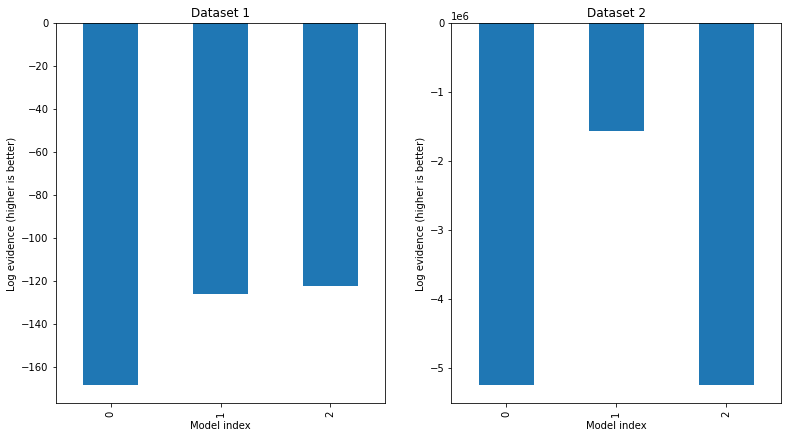

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(13, 7))

plt.axes(axs[0])
df[df['Dataset index'] == 0]['Evidence'].plot.bar()
plt.title('Dataset 1')
plt.xlabel('Model index')
plt.xticks(ticks=[0, 1, 2], labels=[0, 1, 2])
plt.ylabel('Log evidence (higher is better)')

plt.axes(axs[1])
df[df['Dataset index'] == 1]['Evidence'].plot.bar()
plt.title('Dataset 2')
plt.xlabel('Model index')
plt.xticks(ticks=[0, 1, 2], labels=[0, 1, 2])
plt.ylabel('Log evidence (higher is better)');

# 3c

The model with the highest evidence on the second dataset is the second model (index 1), with

$$
\phi(x, \textbf{z}) = (\exp(- \dfrac{(x-1)^2}{z_1^2}), \exp(- \dfrac{(x-5)^2}{z_2^2}))^T
$$

and $\textbf{z} = (z_1, z_2)^T$. The posterior mean and variance can be calculated using Bishop, 3.49 (with 3.50 and 3.51):

$$
p(\textbf{w} | \mathcal{D}) = \mathcal{N}(\textbf{w}| m_N, S_N)
$$

with

$$
m_N = S_N (S_0^{-1} m_0 + \beta \Phi^T \textbf{t}
$$

$$
S_N^{-1} = S_0^{-1} + \beta \Phi^T \Phi
$$

Thus:

In [21]:
z_hat, alpha_hat, sigma_hat, likelihood_history, alpha_history, sigma_history = results[3]
phi_xz = model_2(dataset_2['x'], z_hat)

prior_mean = np.zeros((2, 1))
S_N = (1 / alpha_hat) * np.identity(2) + (1 / sigma_hat) * phi_xz.T @ phi_xz
m_N = np.linalg.inv(S_N) @ ((1 / alpha_hat) * np.identity(2) @ prior_mean + (1 / sigma_hat) * phi_xz.T @ dataset_2['y'])

print(f'Posterior mean: \n{m_N}, \n\nposterior variance: \n{S_N}')

Posterior mean: 
[[0.07250421]
 [0.07255212]], 

posterior variance: 
[[1.05111259 0.03962688]
 [0.03962688 1.05113985]]
